# Literature:

*   [Nist 19 Official database](https://www.nist.gov/srd/nist-special-database-19)
*   [Official NIST paper, database description](https://s3.amazonaws.com/nist-srd/SD19/sd19_users_guide_edition_2.pdf)

---


*   [LeCunn MNIST Database](http://yann.lecun.com/exdb/mnist/)
*  [MNIST paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)

---


*   [EMNIST dataset](https://www.nist.gov/itl/iad/image-group/emnist-dataset)
*   [EMNIST paper](https://arxiv.org/pdf/1702.05373v1.pdf)



# Mount drive and import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os                     # for basic os operations
from zipfile import ZipFile   # for unzip NIST by_class.zip dataset
import pandas as pd           # to store information about images
import numpy as np
import math

from skimage import color, io, transform  # import modules for visualise image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random  # random choose

import cv2  # image processing
from scipy import ndimage

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier  # Estimate the quality of custers
from sklearn.metrics import accuracy_score

from skimage.util import random_noise  # for noise
from sklearn.utils import shuffle      # for shuffle

%matplotlib inline

# Extract images to ./by_class

In [0]:
%%time

PATH = './drive/My Drive/ni_sem/by_class.zip' # path to .zip file
archive = ZipFile(PATH, 'r')
archive.extractall('./')  

archive.close()
del archive

CPU times: user 2min 17s, sys: 1min 7s, total: 3min 25s
Wall time: 4min 22s


# Extract information

In [0]:
!ls ./by_class  # labels, 0-9, a-z, A-Z

30  34	38  43	47  4b	4f  53	57  61	65  69	6d  71	75  79
31  35	39  44	48  4c	50  54	58  62	66  6a	6e  72	76  7a
32  36	41  45	49  4d	51  55	59  63	67  6b	6f  73	77
33  37	42  46	4a  4e	52  56	5a  64	68  6c	70  74	78


In [0]:
!ls -l ./by_class/30  # files in dir hierarhy

total 4964
drwxr-xr-x 2 root root  208896 Mar 28 10:35 hsf_0
-rw-r--r-- 1 root root  293857 Mar 28 10:35 hsf_0.mit
drwxr-xr-x 2 root root  204800 Mar 28 10:35 hsf_1
-rw-r--r-- 1 root root  290593 Mar 28 10:35 hsf_1.mit
drwxr-xr-x 2 root root  196608 Mar 28 10:35 hsf_2
-rw-r--r-- 1 root root  284241 Mar 28 10:35 hsf_2.mit
drwxr-xr-x 2 root root  245760 Mar 28 10:35 hsf_3
-rw-r--r-- 1 root root  351274 Mar 28 10:35 hsf_3.mit
drwxr-xr-x 2 root root  200704 Mar 28 10:35 hsf_4
-rw-r--r-- 1 root root  295424 Mar 28 10:35 hsf_4.mit
drwxr-xr-x 2 root root  208896 Mar 28 10:35 hsf_6
-rw-r--r-- 1 root root  315884 Mar 28 10:35 hsf_6.mit
drwxr-xr-x 2 root root  237568 Mar 28 10:35 hsf_7
-rw-r--r-- 1 root root  313416 Mar 28 10:35 hsf_7.mit
drwxr-xr-x 2 root root 1421312 Mar 28 10:35 train_30


In [0]:
!head ./by_class/30/hsf_0.mit  # content of information about label

5534
hsf_0_00000.png f0000_14/d0000_14/d0000_14_00000.png
hsf_0_00001.png f0000_14/d0000_14/d0000_14_00010.png
hsf_0_00002.png f0000_14/d0000_14/d0000_14_00018.png
hsf_0_00003.png f0000_14/d0000_14/d0000_14_00025.png
hsf_0_00004.png f0000_14/d0000_14/d0000_14_00031.png
hsf_0_00005.png f0000_14/d0000_14/d0000_14_00034.png
hsf_0_00006.png f0000_14/d0000_14/d0000_14_00037.png
hsf_0_00007.png f0000_14/d0000_14/d0000_14_00040.png
hsf_0_00008.png f0000_14/d0000_14/d0000_14_00047.png


In [0]:
Info = {} 
for label in range(48, 58):  # from '0' to '9'
  Info[chr(label)] = []
Info

{'0': [],
 '1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': []}

In [0]:
for root, dirs, files in os.walk('./by_class'):  # recursive traverse of directory
  if root.split('/')[-1].startswith('hsf_'):  # appropriate original folder
    for file in files:
      if file.endswith('.png'):
        label = chr(int(root.split('/')[2], 16))  # parse gt label
        if label in Info.keys():  # if its a label of digit
          Info[label].append(os.path.join(root, file))  # appropriate path

# Check Info

In [0]:
no = 0  # smal validation check and count no of images

for label in Info.keys():
  print(label, '(count:', len(Info[label]), '):', Info[label][0:5])
  no += len(Info[label])
  
print(no)

0 (count: 40363 ): ['./by_class/30/hsf_3/hsf_3_05902.png', './by_class/30/hsf_3/hsf_3_06165.png', './by_class/30/hsf_3/hsf_3_03753.png', './by_class/30/hsf_3/hsf_3_01967.png', './by_class/30/hsf_3/hsf_3_01717.png']
1 (count: 44704 ): ['./by_class/31/hsf_3/hsf_3_05902.png', './by_class/31/hsf_3/hsf_3_06165.png', './by_class/31/hsf_3/hsf_3_03753.png', './by_class/31/hsf_3/hsf_3_01967.png', './by_class/31/hsf_3/hsf_3_01717.png']
2 (count: 40072 ): ['./by_class/32/hsf_3/hsf_3_05902.png', './by_class/32/hsf_3/hsf_3_06165.png', './by_class/32/hsf_3/hsf_3_03753.png', './by_class/32/hsf_3/hsf_3_01967.png', './by_class/32/hsf_3/hsf_3_01717.png']
3 (count: 41112 ): ['./by_class/33/hsf_3/hsf_3_05902.png', './by_class/33/hsf_3/hsf_3_06165.png', './by_class/33/hsf_3/hsf_3_03753.png', './by_class/33/hsf_3/hsf_3_01967.png', './by_class/33/hsf_3/hsf_3_01717.png']
4 (count: 39154 ): ['./by_class/34/hsf_3/hsf_3_05902.png', './by_class/34/hsf_3/hsf_3_03753.png', './by_class/34/hsf_3/hsf_3_01967.png', './

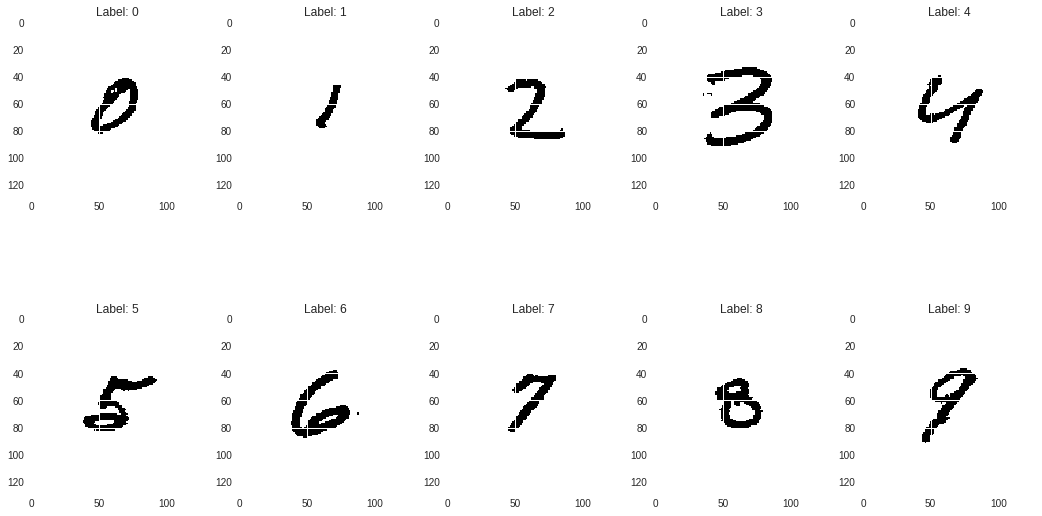

In [0]:
ax0 = (i for i in range(0, 5))  # define axes
ax1 = (i for i in range(5, 10))
    
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=5, figsize=(18, 10))

for i in range(0, 5):  # first row
  ax0[i].set_title('Label: '+str(i))
  img = io.imread(Info[str(i)][random.randint(0, len(Info[str(i)]))])  # random choose one of images
  ax0[i].imshow(img)

for i in range(0, 5):  # second row
  ax1[i].set_title('Label: '+str(i+5))
  img = io.imread(Info[str(i+5)][random.randint(0, len(Info[str(i+5)]))])  # random choose one of images
  ax1[i].imshow(img)

plt.show()

# Random choose 120_000+20_000 (10x12_000, 10x2_000)

In [0]:
for label in Info:  # randomize
  random.shuffle(Info[str(label)])

In [0]:
for label in Info:  # crop
  Info[str(label)] = Info[str(label)][:14_000]  # first 12k is train, last 2k is test set

In [0]:
len(Info['0'])  # it's ok

14000

# Image Processing

## Manual on one image

In [0]:
BOX_SIZE = 56  # define part
OFFSET = 2
PATH = Info['5'][0]

(128, 128, 3)


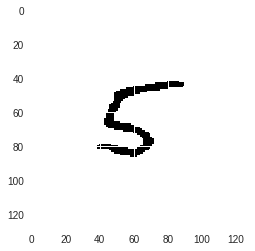

In [0]:
img = io.imread(PATH)  # load original image
print(img.shape)
plt.imshow(img)
plt.show()

(128, 128)


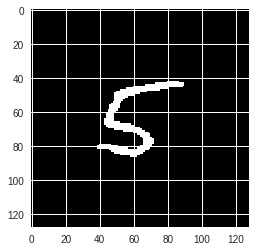

In [0]:
img = color.rgb2gray(img)  # convert to grayscale
print(img.shape)
plt.imshow(img)
plt.show()

(42, 86) x (39, 89)


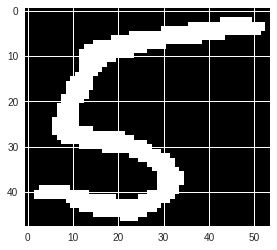

In [0]:
for v in range(0, 128):  # crop image
  if not (np.all(img[v])==1):
    break
v_min = v
for v in range(127, -1, -1):
  if not (np.all(img[v])==1):
    break
v_max = v

for k in range(0, 128):
  if not np.all(img[:,k])==1:
    break;
k_min = k
for k in range(127, -1, -1):
  if not np.all(img[:,k])==1:
    break;
k_max = k

print((v_min, v_max), 'x', (k_min, k_max))

#img = ndimage.gaussian_filter(img, sigma=1)  # First Add Gaussian noise to soften the margin
#plt.imshow(img)  
#plt.show()

img = img[max(v_min-OFFSET, 0):min(v_max+OFFSET, 128), max(k_min-OFFSET, 0):min(k_max+OFFSET, 128)] # Then crop the image; 
plt.imshow(img)  # min and max added for security
plt.show()

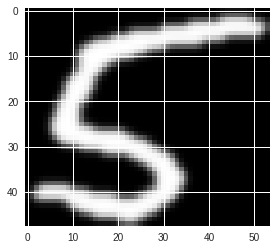

In [0]:
img = ndimage.gaussian_filter(img, sigma=1)  # First Add Gaussian noise to soften the margin
plt.imshow(img)  
plt.show()

(54, 54)


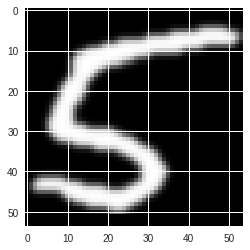

In [0]:
height, width = img.shape
box_size = max(height, width)  # PADDING is already added
new_img = np.ones(shape=(box_size, box_size))

left = (box_size-height)//2  # calculate translation factor
right = (box_size-width)//2

new_img[left:left+height, right:right+width] = img  # position image to center of square image
img = new_img

print(img.shape)
plt.imshow(img)
plt.show()

(56, 56)


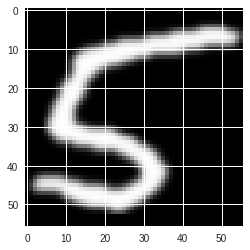

In [0]:
new_img = np.zeros(shape=(BOX_SIZE, BOX_SIZE), dtype=np.uint8)
new_img.fill(255)
tmp_img = cv2.resize(src=img, dsize=(BOX_SIZE, BOX_SIZE), interpolation=cv2.INTER_AREA)  # imresize with bicubic interpolation
img = tmp_img

print(img.shape)
plt.imshow(img)
plt.show()

(56, 56)


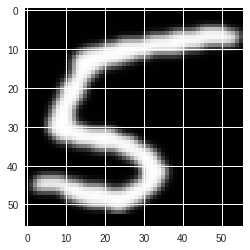

In [0]:
for i in range(img.shape[0]):  # convert to 8bit grayscale images; pixels from float [0,1] -> uint [0,256)
  for j in range(img.shape[1]):
      img[i][j] = int(min(img[i][j], 1)*255)  # fix small numeric computation error
      
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
img[40]

array([254., 254., 254., 254., 254., 254., 254., 254., 254., 254., 254.,
       254., 254., 254., 254., 254., 254., 254., 254., 254., 254., 254.,
       254., 254., 254., 251., 246., 232., 191., 121.,  50.,  12.,   4.,
        15.,  51., 116., 188., 234., 251., 254., 254., 255., 255., 255.,
       255., 254., 254., 255., 255., 255., 254., 254., 255., 254., 255.,
       255.])

## Functions

In [0]:
BOX_SIZE = 56  # define mart
OFFSET = 2 

In [0]:
def read_gray(path):  # read image and convert it to grayscale
  """
  return grayscale image in shape (128, 128)
  """
  img = io.imread(path) 
  img = color.rgb2gray(img)
  return img

In [0]:
def crop_image(img):
  """
  return cropped image, with border (size OFFSET)
  use of global object: OFFSET
  """
  for v in range(0, 128):  # find start and end in columns and rows
    if not (np.all(img[v])==1):
      break
  v_min = v
  for v in range(127, -1, -1):
    if not (np.all(img[v])==1):
      break
  v_max = v

  for k in range(0, 128):
    if not np.all(img[:,k])==1:
      break;
  k_min = k
  for k in range(127, -1, -1):
    if not np.all(img[:,k])==1:
      break;
  k_max = k
  
  img = img[max(v_min-OFFSET, 0):min(v_max+OFFSET, 128), max(k_min-OFFSET, 0):min(k_max+OFFSET, 128)] # Then crop the image
  return img

In [0]:
def add_noise(img, noise_function): 
  """
  return noised image
  """
  return noise_function(img)

def add_gaussian_noise(img, sigma=1):
  """
  add Gaussian filter to image
  Use default params: sigma=1
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

In [0]:
def square_image(img):
  """
  return image squared to bigger dimension: max(height, width) x max(height, width)
  """
  height, width = img.shape
  box_size = max(height, width)  
  new_img = np.ones(shape=(box_size, box_size))

  left = (box_size-height)//2  # calculate translation factor
  right = (box_size-width)//2

  new_img[left:left+height, right:right+width] = img  # position image to center of square image
  return new_img

In [0]:
def resize_image(img, interp):
  """
  resize image with appropriate interpolation
  Use of global object: BOX_SIZE
  """
  new_img = np.zeros(shape=(BOX_SIZE, BOX_SIZE), dtype=np.uint8)
  new_img.fill(255)
  tmp_img = cv2.resize(src=img, dsize=(BOX_SIZE, BOX_SIZE), interpolation=interp)  # imresize with bicubic interpolation
  return tmp_img

In [0]:
def to8bit(img):  
  """
  convert binary image to 8bit gray image
  """
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img[i][j] = int(min(img[i][j], 1)*255)  # use max(1,..) to handle small numeric errors
  return img

(56, 56)


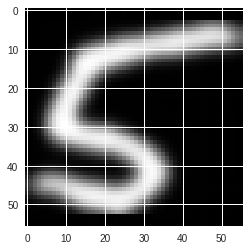

[255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 254. 254. 255. 255. 255. 254. 254. 255. 254. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 254. 254. 255. 255. 255. 254. 254. 255. 254. 255. 255.]


In [0]:
img = read_gray(PATH)  # check
img = crop_image(img)
img = add_noise(img, add_gaussian_noise)  # Gaussian noise
img = square_image(img)
img = resize_image(img, cv2.INTER_AREA)  # Bicubic interpolation
img = to8bit(img)

print(img.shape)
plt.imshow(img)
plt.show()

print(img[0])

In [0]:
import functools
def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)
  
def parse_image(interp, noise_function):
  """
  return image parser with desired interpolation and noise function
  """
  parser = compose(to8bit, functools.partial(resize_image, interp=interp), square_image, functools.partial(add_noise, noise_function=noise_function), crop_image, read_gray)
  return parser

# Evaluate best noise and interpolation

## Evauate: Gaussian + Bicubuc

(56, 56)


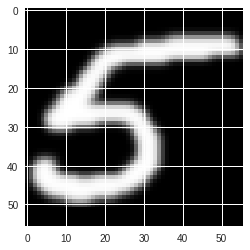

In [0]:
def add_gaussian_noise(img, sigma=1):
  """
  add Gaussian filter to image
  Use default params: sigma=1
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 30.8 s, sys: 973 ms, total: 31.8 s
Wall time: 31.8 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.9515
CPU times: user 2min 53s, sys: 25.2 ms, total: 2min 53s
Wall time: 2min 53s


## Evaluate: Gaussian + Lanczos 

(56, 56)


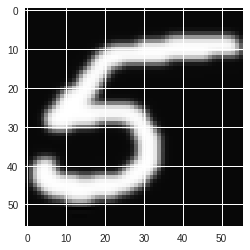

In [0]:
def add_gaussian_noise(img, sigma=1):
  """
  add Lanczos filter to image
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

parser = parse_image(cv2.INTER_LANCZOS4, add_gaussian_noise)  #  a Lanczos interpolation over 8x8 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 31.3 s, sys: 934 ms, total: 32.3 s
Wall time: 32.3 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.95
CPU times: user 3min, sys: 16.7 ms, total: 3min
Wall time: 3min


## Evaluate: Gaussian + Bilinear 

(56, 56)


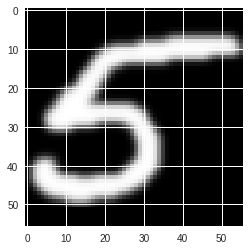

In [0]:
def add_gaussian_noise(img, sigma=1):
  """
  add Gaussian filter to image
  Use default params: sigma=1
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

parser = parse_image(cv2.INTER_LINEAR, add_gaussian_noise)  #  a bilinear interpolation (used by default)

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 30.9 s, sys: 1.01 s, total: 32 s
Wall time: 32 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.951
CPU times: user 2min 52s, sys: 14.8 ms, total: 2min 52s
Wall time: 2min 52s


## Evaluate: Sobel filter + Bicubic

(56, 56)


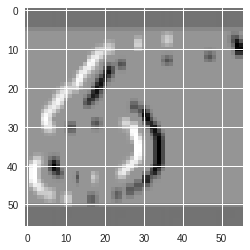

In [0]:
def add_sobel_filter(img, sigma=1):
  """
  add sobel filter to image
  """
  return ndimage.filters.sobel(img)

parser = parse_image(cv2.INTER_AREA, add_sobel_filter)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 28.5 s, sys: 1.04 s, total: 29.5 s
Wall time: 29.5 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.771
CPU times: user 3min 10s, sys: 21.3 ms, total: 3min 10s
Wall time: 3min 10s


## Evaluate: Prewitt filter + Bicubic

(56, 56)


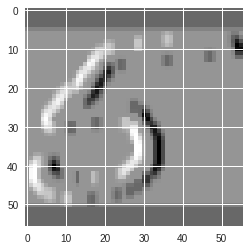

In [0]:
def add_prewitt_filter(img, sigma=1):
  """
  add prewitt filter to image
  """
  return ndimage.filters.prewitt(img)

parser = parse_image(cv2.INTER_AREA, add_prewitt_filter)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 28.7 s, sys: 1.06 s, total: 29.8 s
Wall time: 29.8 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.774
CPU times: user 3min 10s, sys: 32.1 ms, total: 3min 10s
Wall time: 3min 10s


## Evaluate: Laplace + Bicubic

(56, 56)


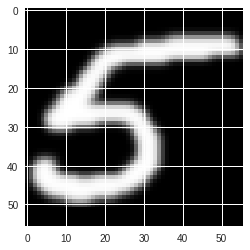

In [0]:
def add_laplace_gaussian_filter(img, sigma=1):
  """
  add Gaussian Laplace filter to image
  Use default params: sigma=1
  """
  return ndimage.ndimage.filters.gaussian_laplace(img, sigma=sigma)

parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 30.4 s, sys: 928 ms, total: 31.4 s
Wall time: 31.4 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.9515
CPU times: user 2min 51s, sys: 24.7 ms, total: 2min 51s
Wall time: 2min 51s


## Evaluate: Fourier Gaussian + Bicubic

(56, 56)


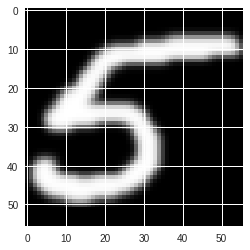

In [0]:
def add_fourier_gaussian_filter(img, sigma=1):
  """
  add Fourier Gaussian filter to image
  Use default params: sigma=1
  """
  return ndimage.fourier.fourier_gaussian(img, sigma=sigma)

parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 31.1 s, sys: 1.03 s, total: 32.1 s
Wall time: 32.1 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.9515
CPU times: user 2min 51s, sys: 15.3 ms, total: 2min 51s
Wall time: 2min 51s


## Piosson + Bicubic

(56, 56)


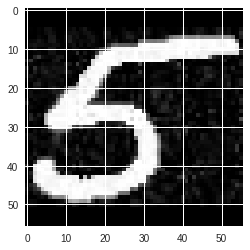

In [0]:
def add_poisson_noise(img, sigma=1):
  """
  add Fourier Gaussian filter to image
  Use default params: sigma=1
  """
  return random_noise(img, mode='gaussian')

parser = parse_image(cv2.INTER_AREA, add_poisson_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 30.2 s, sys: 1.07 s, total: 31.3 s
Wall time: 31.3 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.938
CPU times: user 3min 8s, sys: 24.5 ms, total: 3min 8s
Wall time: 3min 8s


## Speckle + Bicubic

(56, 56)


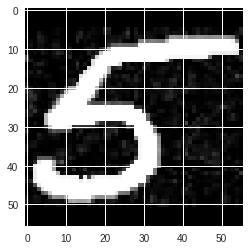

In [0]:
def add_speckle_noise(img, sigma=1):
  """
  add speckle nioise to image
  """
  return random_noise(img, mode='speckle')

parser = parse_image(cv2.INTER_AREA, add_speckle_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 29.9 s, sys: 873 ms, total: 30.7 s
Wall time: 30.7 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.937
CPU times: user 3min 9s, sys: 29.8 ms, total: 3min 9s
Wall time: 3min 9s


## Gaussian + Bicubic (sigma=3)

(56, 56)


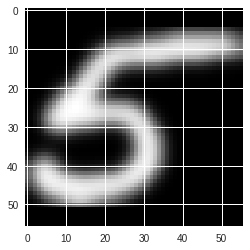

In [0]:
def add_gaussian_noise(img, sigma=2):
  """
  add Gaussian filter to image
  Use default params: sigma=3
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
%%time

x_train = []  # 12k
y_train = []
x_test = []   # 2k
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label]), 10):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img.flatten())  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img.flatten())  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

12000
12000
2000
2000
CPU times: user 31.6 s, sys: 1.01 s, total: 32.6 s
Wall time: 32.6 s


In [0]:
%%time

knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
knn.fit(x_train, y_train)  

score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
print(score)

0.9595
CPU times: user 2min 47s, sys: 31.8 ms, total: 2min 47s
Wall time: 2min 47s


# Test of choosen params

(56, 56)


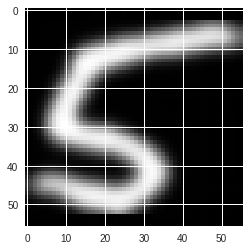

In [0]:
def add_gaussian_noise(img, sigma=2):
  """
  add Gaussian filter to image
  Use default params: sigma=2 (standard deviation)
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)  # a bicubic interpolation over 4x4 pixel neighborhood

img = parser(PATH)  # small check
print(img.shape)
plt.imshow(img)
plt.show()

In [0]:
img # small test

array([[255., 255., 255., ..., 254., 255., 255.],
       [255., 255., 255., ..., 254., 255., 255.],
       [255., 255., 255., ..., 254., 255., 255.],
       ...,
       [254., 254., 254., ..., 254., 255., 254.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 254., 255., 255.]])

In [0]:
%%time

sumscore = 0

for start in range(0, 10):
  x_train = []  # 12k
  y_train = []
  x_test = []   # 2k
  y_test = []

  for label in Info.keys():  # Traverse by labels
    for i in range(start, len(Info[label]), 10):  # Traverse by paths
      img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
      if i<12_000:
        x_train.append(img.flatten())  # Append to train set 
        y_train.append(label)
      else:
        x_test.append(img.flatten())  # Append to test set
        y_test.append(label)
      
  knn = KNeighborsClassifier(n_neighbors=1, metric='l2')  # approx ~ 1nn
  knn.fit(x_train, y_train)  

  score = accuracy_score(y_test, knn.predict(x_test))  # check acc score
  print('start: ', start, 'score: ', score)
  sumscore += score
  
  del x_train  # delete unnesessary parts of code
  del y_train
  del x_test
  del y_test
  del knn
  
print('Avg: ', sumscore/10)

start:  0 score:  0.9695
start:  1 score:  0.956
start:  2 score:  0.963
start:  3 score:  0.9595
start:  4 score:  0.9475
start:  5 score:  0.9645
start:  6 score:  0.963
start:  7 score:  0.9665
start:  8 score:  0.957
start:  9 score:  0.9685
Avg:  0.9615
CPU times: user 40min 10s, sys: 11.2 s, total: 40min 22s
Wall time: 40min 22s


# Create dataset

In [0]:
!rm -rf DoubledMNIST/  # if folder exist, delete

In [0]:
disk = './DoubledMNIST'  # create folder tree
train_path = os.path.join(disk, 'train')
test_path = os.path.join(disk, 'test')

if not os.path.exists(disk):
  os.makedirs(disk)
if not os.path.exists(train_path):
  os.makedirs(train_path)
if not os.path.exists(test_path):
  os.makedirs(test_path)

In [0]:
def add_gaussian_noise(img, sigma=2):
  """
  add Gaussian filter to image
  Use default params: sigma=3
  """
  return ndimage.gaussian_filter(img, sigma=sigma)

parser = parse_image(cv2.INTER_AREA, add_gaussian_noise)  # bicubic intetrpolation and Gaussian noise

In [0]:
%%time

x_train = []  # 12kx10
y_train = []
x_test = []   # 2kx10
y_test = []

for label in Info.keys():  # Traverse by labels
  for i in range(0, len(Info[label])):  # Traverse by paths
    img = np.array(parser(Info[label][i]))  # preprocess image to 56x56 normalised grayscale np array
    if i<12_000:
      x_train.append(img)  # Append to train set 
      y_train.append(label)
    else:
      x_test.append(img)  # Append to test set
      y_test.append(label)
      
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

120000
120000
20000
20000
CPU times: user 15min 2s, sys: 21.3 s, total: 15min 23s
Wall time: 15min 23s


In [0]:
print(len(x_train))  # small check, should be 120 000
print(len(x_test))  # small check, should be 20 000

120000
20000


In [0]:
def shuffle_both(list1, list2):
  """
  shuffle both list simultaneously
  """
  if type(list1)!=list or type(list2)!=list:
    raise ValueError("Error: function shuffle only list")
  if len(list1)!=len(list2):
    raise ValueError("Error: list must be the same length")
    
  list1, list2 = shuffle(list1, list2)
  return list1, list2

In [0]:
x_train, y_train = shuffle_both(x_train, y_train) # randomise order of images in dataset
x_test, y_test = shuffle_both(x_test, y_test)

In [0]:
%%time
for i in range(len(x_train)):
  img = x_train[i]
  io.imsave(os.path.join(train_path, 'image_'+str(y_train[i])+'_'+str(i)+'.png'), img.astype(np.uint8))  # file name encode label: 
  
for i in range(len(x_test)):
  img = x_test[i]
  io.imsave(os.path.join(test_path, 'image_'+str(y_test[i])+'_'+str(i)+'.png'), img.astype(np.uint8))  # file name encode label: 

CPU times: user 1min 23s, sys: 10.7 s, total: 1min 34s
Wall time: 1min 35s


In [0]:
x_train[0][0].astype(np.uint8)

array([255, 255, 255, 255, 254, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 254, 254, 254, 254, 254, 254, 254, 254, 254, 253,
       251, 249, 242, 237, 231, 221, 217, 212, 212, 213, 219, 226, 230,
       236, 246, 255, 255, 255, 255, 255, 254, 255, 255, 255, 255, 255,
       255, 255, 255, 255], dtype=uint8)

In [0]:
# Small test; check
total = 0
for root, dirs, files in os.walk("./DoubledMNIST/train"):
  for f in files:
    if f.endswith('.png'):
      total += 1

print(total)

120000


In [0]:
# Small test; check
total = 0
for root, dirs, files in os.walk("./DoubledMNIST/test"):
  for f in files:
    if f.endswith('.png'):
      total += 1

print(total)

20000


In [0]:
!ls ./DoubledMNIST/train | wc -l  # Its ok: 2+140_000+20_000

120000


In [0]:
!ls ./DoubledMNIST/test | wc -l  # Its ok: 2+140_000+20_000

20000


(56, 56)


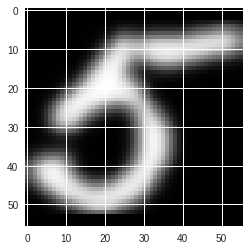

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [0]:
# load image and plot it! small check
path = './DoubledMNIST/test/image_5_10040.png'
img = io.imread(path)  # load original image
print(img.shape)
plt.imshow(img)
plt.show()

print(img)

In [0]:
%%time

import shutil
shutil.make_archive("DoubledMNIST", 'zip', "DoubledMNIST")

!ls -lsh

!mv ./DoubledMNIST.zip './drive/My Drive/ni_sem/'

!ls -lsh './drive/My Drive/ni_sem/'

total 217M
4.0K drwxr-xr-x 64 root root 4.0K Mar 28 10:37 by_class
4.0K drwxr-xr-x  4 root root 4.0K Mar 28 13:35 DoubledMNIST
217M -rw-r--r--  1 root root 217M Mar 28 13:56 DoubledMNIST.zip
4.0K drwx------  3 root root 4.0K Mar 28 10:32 drive
4.0K drwxr-xr-x  1 root root 4.0K Mar  8 17:26 sample_data
total 1.2G
984M -rw-------  1 root root 984M Mar 26 11:40 by_class.zip
3.5K -rw-------  1 root root 3.2K Mar 27 12:25 constr.ipynb
289K -rw-------  1 root root 289K Mar 28 13:55 DoubledMNIST.ipynb
217M -rw-------+ 1 root root 217M Mar 28 13:56 DoubledMNIST.zip
 16K -rw-------  1 root root  16K Mar 28 10:29 Untitled0.ipynb
CPU times: user 24.3 s, sys: 4.25 s, total: 28.6 s
Wall time: 35.7 s
